In [13]:
# Data munging / maths
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

# Model
from xgboost import XGBClassifier

# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Import OS stuff
import os

# Import mlflow stuff
import mlflow
import mlflow.xgboost
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType

# Import utils
from utils.plot_learning import plot_learning
from utils.load_data import load_data

In [14]:
def log_xgboost(params, train_X, train_Y, validation_X, validation_Y):
    """ Takes a set of xgboost parameters, trains a model and logs parameters, metrics, artifacts and the model itself.

        args:
            params: Dictionary of xgboost parameters
            train_X: pandas dataframe containing training features
            train_Y: pandas dataframe containing training labels
            test_X: pandas data
    """
    with mlflow.start_run() as ml_run:
        
        # Her logger vi alle parameterene paa vei inn
        for k, v in params.items():
            mlflow.log_param(k, v)
        
        # Setter tag, her kan beste modell settes til "prod" senere
        mlflow.set_tag("state", "dev")
        
        # Setter opp modell som vanlig
        xgc = XGBClassifier(objective="binary:logistic")
        xgc.set_params(**params)
        model = xgc.fit(train_X,
                        train_Y.values.ravel(),
                        eval_set=[(train_X, train_Y.values.ravel()), (validation_X, validation_Y.values.ravel())],
                        eval_metric=['error', 'logloss'], verbose=0)
        
        # Henter validation predictions, kalkulerer accuracy og loss
        predictions = model.predict(validation_X)
        acc = accuracy_score(validation_Y.values.ravel(), predictions)
        loss = log_loss(validation_Y.values.ravel(), predictions)

        # Logging av loss og accuracy verdier (metrics)
        mlflow.log_metrics({'log_loss': loss, 'accuracy': acc})
        
        # Logging av ulike plots (artifacts)

        # Trening/valideringserror for ulike n_estimator verdier
        error_plot = plot_learning(model, "error")
        error_plot.savefig("temp/error_plot.png")
        mlflow.log_artifact("temp/error_plot.png")

        # Trening/valideringsloss for ulike n_estimator-verdier
        loss_plot = plot_learning(model, "logloss")
        loss_plot.savefig("temp/logloss.png")
        mlflow.log_artifact("temp/logloss.png")

        # Confusion matrix for klassifisering
        conf_mat = confusion_matrix(validation_Y, predictions)
        conf_mat_plot = sns.heatmap(conf_mat, annot=True, fmt='g')
        conf_mat_plot.figure.savefig("temp/confmat.png")
        mlflow.log_artifact("temp/confmat.png")

        # Logging av selve modellen
        mlflow.xgboost.log_model(model, "model")
        
        print(f"Model trained with parameters: {params}")
        
        return ml_run.info.run_id, acc, loss


In [15]:
def get_predictions(host, port, data):
    """ Takes a host ip, port and pandas dataframe and returns predictions from model endpoint."""
    
    # Serving URL
    url = f'http://{host}:{port}/invocations'
    
    # Header, format defaults to split orient json
    headers = {
    'Content-Type': 'application/json'
    }

    # Transform df to split oriented json
    http_data = data.to_json(orient='split')

    # Send post request
    r = requests.post(url=url, headers=headers, data=http_data)
    print(r)

    # Return predictions
    return pd.DataFrame({"predictions": json.loads(r.text)})

Model trained with parameters: {'max_depth': 7, 'gamma': 0, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'n_estimators': 200, 'n_jobs': -1}
run_path: runs:/333dab3498944db7bab58892ea4817d2/model, accuracy: 0.7895335608646189, loss: 7.269308769626528


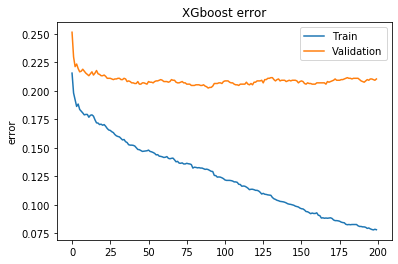

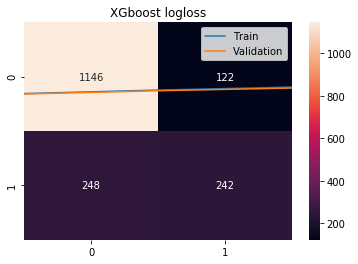

In [16]:
# Load in data    
train_X, train_Y, test_X, test_Y = load_data("data/telco_churn.csv", test_size = 0.25)

plt.rcParams.update({'figure.max_open_warning': 0})

# Sett opp nytt eksperiment om det ikke eksisterer allerede
experiment_name = "da_demo_xgboost"
client = mlflow.tracking.MlflowClient()
mlflow.set_experiment(experiment_name)
experiments = client.list_experiments()
if experiment_name not in [experiment.name for experiment in experiments]:
    mlflow.create_experiment(experiment_name)

params = {
# XGboost parameters
    'max_depth': 7,
    'gamma': 0,
    'learning_rate': 0.1,
    'colsample_bytree': 0.3,
    'n_estimators': 200,
    'n_jobs': -1
}

run_id, accuracy, loss = log_xgboost(params, train_X, train_Y, test_X, test_Y)

print(f"run_path: runs:/{run_id}/model, accuracy: {accuracy}, loss: {loss}")



In [ ]:
run = client.search_runs(
    experiment_ids="1",
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"]
)[0]

# Get path to saved xgb model artifact
# Could also here set tag for this model to "prod"
xgb_model_path = f"runs:/{run.info.run_id}/model"

#os.system(f"mlflow models serve -m {xgb_model_path} -p 5004")
os.system(f"mlflow models build-docker -m {xgb_model_path} -n xgb_da_mote")
#os.system(f"mlflow sagemaker run-local -m {xgb_model_path} -n xgb_da_mote")
#os.system(f"mlflow sagemaker build-docker -m {xgb_model_path} -n xgb_da_mote")

In [ ]:
## Feature engineering "pipeline"
inference_X = load_data("new_data/new_data.csv", inference = True)[0]

# Set host and port
host = "0.0.0.0"
port = "5004"

# Get predictions
predictions = get_predictions(host, port, inference_X)
print(predictions.head())

# Write predictions to csv
predictions.to_csv("predictions/predictions.csv")
print("Wrote predictions to predicitons/predictions.csv")
